# Main workflow 'Automated quality-controlled left heart segmentation from 2D echocardiography'

This notebook provides a workflow to automatically compute currently relevant clinical indices using the segmentations of the left ventricular cavity (LV<sub>cav</sub>), myocardium (LV<sub>myo</sub>), and left atrium (LA) from 2D echocardiography. Two separate quality control (QC) steps are incorporated to (1) select frames for post-processing and (2) exclude images with bad or temporally inconsistent segmentations. 

>It is assumed that the segmentation will consist of all three structures, with the following labels: <br>
> * 0: background <sub>  </sub>
> * 1: LV<sub>cav</sub>
> * 2: LV<sub>myo</sub>
> * 3: LA <sub>  </sub>
 
**Includes:** 
* [Set paths to access data](#Paths-to-data) 
* [Get image acquisition properties from DICOM files](#get-image-acquisition-properties-from-dicom-files) 
  - Timing of frames
  - Spacing of pixels
  - R-wave peaks
* [Get image and segmentation parameters](#get-image-and-segmentation-parameters)
  - LV<sub>cav</sub>, LV<sub>myo</sub>, and LA areas
  - Frames in end-diastole (ED) and end-systole (ES) 
  - [Get overview of images and segmentations](#create-figure-with-image-and-segmentation-and-areas-over-time)
* [Do single-frame QC](#single-frame-quality-control)
* [Do post-processing](#post-processing)
* [Cycle selection](#cycle-selection)
* Do multi-frame QC
* Calculate clinical indices
  - LV volumes in ED and ES
  - LV ejection fraction (EF)
  - LV endocardial global longitudinal strain (GLS)
  - LA maximum area

## Import python libraries

In [1]:
import os
import numpy as np
import pandas as pd

from image_properties_from_dicom import main_get_dicom_properties
from basic_parameters_from_seg import main_get_parameters
from plot_figures import main_plot_area_time_curves
from single_frame_QC import main_single_frame_QC
from post_processing import main_post_processing

## Paths to data
A description of how to correctly set up the paths with images and segmentations can be found in this [README](./README.md).

#### Parameters to change

In [2]:
## PARAMETERS TO CHANGE ##
# Define path to folder with all patients
main_folder = r"R:\Sandboxes\Bram\Cardiohance\New_Folder_Structure"

# Define patient of interest, by default the first patient in the main folder
patient = os.listdir(main_folder)[0]

## PARAMETERS TO CHANGE ##

#### Paths

In [3]:
path_to_dicom_files = os.path.join(main_folder, patient, "DICOM_files")
path_to_images = os.path.join(main_folder, patient, "images")
path_to_segmentations = os.path.join(main_folder, patient, "segmentations")
path_to_final_segmentations = os.path.join(main_folder, patient, "final_segmentations")

## Get image acquisition properties from DICOM files
From the DICOM file, the time points of each frame, pixel spacing and R-wave peaks are extracted. 

Please keep in mind that the use of different ultrasound machines, probes and settings can lead to a difference in parameters used for retrieving the data from the DICOM file. Therefore, it could be that the provided code returns an error. 

In [4]:
dicom_properties = main_get_dicom_properties(path_to_dicom_files)

## Get image and segmentation parameters
The following parameters are extracted from the segmentations:
* LV<sub>cav</sub>, LV<sub>myo</sub>, and LA areas
* Frames in end-diastole (ED) and end-systole (ES)

In [5]:
segmentation_properties = main_get_parameters(path_to_segmentations, dicom_properties)

### Create figure with image and segmentation and areas over time

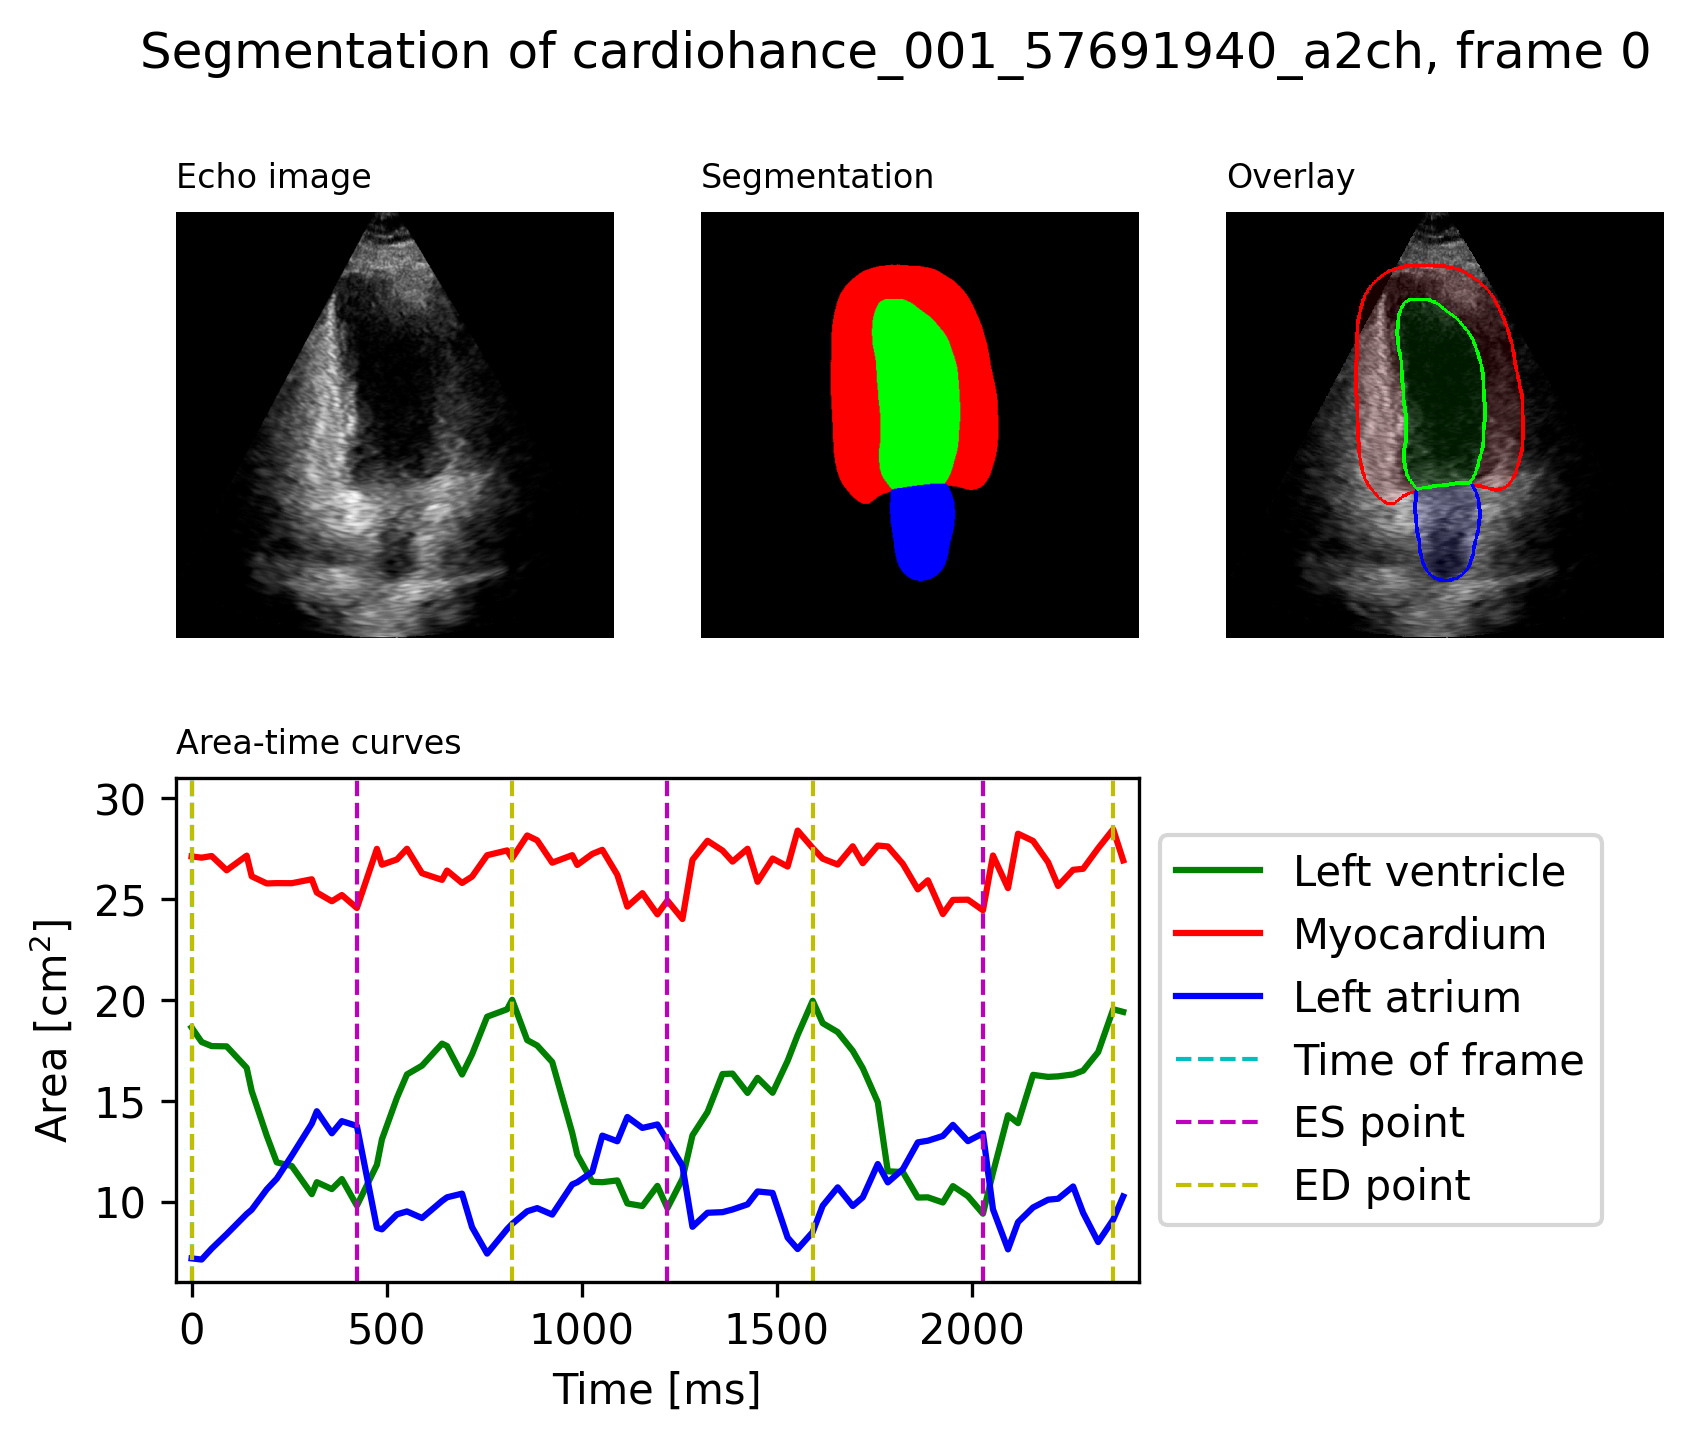

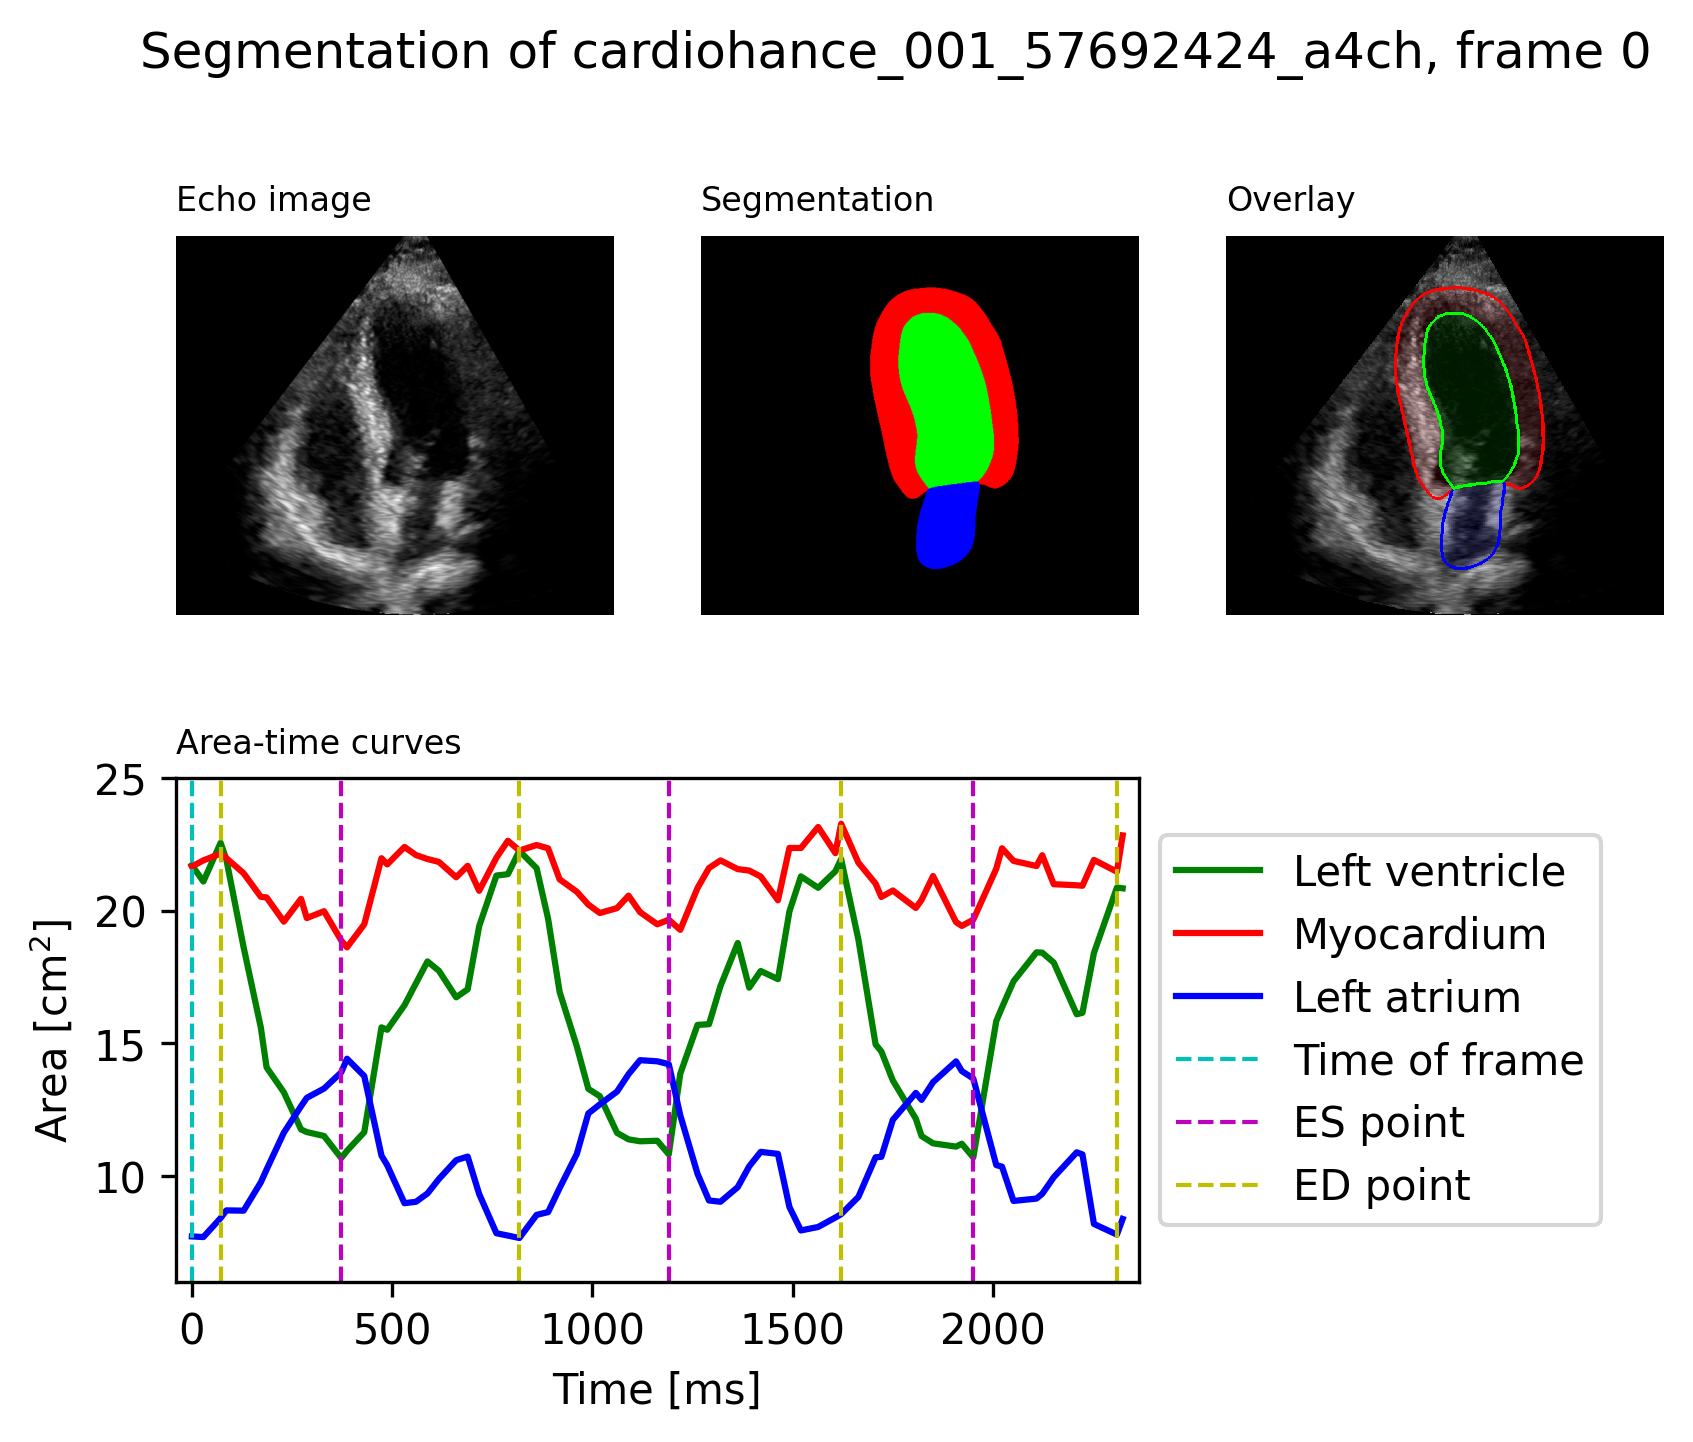

In [6]:
# Define the label colors as an RGB array
colors_for_labels = np.array(
    [
        [0, 0, 0],  # label 0: black (background)
        [0, 255, 0],  # label 1: green (left ventricular cavity)
        [255, 0, 0],  # label 2: red (left ventricular myocardium)
        [0, 0, 255],  # label 3: blue (left atrium)
    ]
)  

main_plot_area_time_curves(
    path_to_images,
    path_to_segmentations,
    dicom_properties,
    segmentation_properties,
    colors_for_labels,
)

## Single-frame quality control
The single-frame QC is based on the following criteria:
* no missing structures for LV, MYO and LA
* no multiple structures for LV, MYO and LA
* no gap within LV, MYO, LA
* no gap between each structure

In [7]:
single_frame_QC_before_post_processing = main_single_frame_QC(path_to_segmentations)

In [8]:
stats_single_frame_QC_before_post_processing = pd.DataFrame.from_dict(
    single_frame_QC_before_post_processing["QC_Stats"],
    orient="index",
    columns=["QC_Stats"],
)
stats_single_frame_QC_before_post_processing

,QC_Stats
Missing structure LV,0
Missing structure MYO,0
Missing structure LA,0
Duplicate structures LV,0
Duplicate structures MYO,0
Duplicate structures LA,0
Holes within LV,0
Holes within MYO,0
Holes within LA,0
Holes between LV and MYO,0


## Post-processing
The post-processing consists of the following steps:
* Determine the mean centroids of the LV<sub>cav</sub>, LV<sub>myo</sub>, and LA accross the entire image sequence. 
* Remove structures that do not contain the mean centroids. 
* Fill holes in the remaining structures.

In [9]:
main_post_processing(
    path_to_segmentations,
    path_to_final_segmentations,
    single_frame_QC_before_post_processing,
)

## Single-frame quality control after post-processing
The single-frame QC is repeated after post-processing, to see if the post-processing improved the segmentation.

In [10]:
single_frame_QC_after_post_processing = main_single_frame_QC(
    path_to_final_segmentations
)

In [11]:
stats_single_frame_QC_after_post_processing = pd.DataFrame.from_dict(
    single_frame_QC_after_post_processing["QC_Stats"],
    orient="index",
    columns=["QC_Stats"],
)
stats_single_frame_QC_after_post_processing

,QC_Stats
Missing structure LV,0
Missing structure MYO,0
Missing structure LA,0
Duplicate structures LV,0
Duplicate structures MYO,0
Duplicate structures LA,0
Holes within LV,0
Holes within MYO,0
Holes within LA,0
Holes between LV and MYO,0


## Cycle selection
The cycle selection is based on the following criteria:
* contrast-to-noise ratio 
* number of flagged images